In [16]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

import sklearn.metrics
import matplotlib
import scipy.stats

matplotlib.rcParams.update({'font.size': 16})

In [17]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/'

In [18]:
#3'UTR table

utr_table = pd.read_csv(data_dir + 'UTR_coords/GRCh38_3_prime_UTR_clean-sorted.bed', sep='\t',
                       header = None, names=['seq_start','seq_end','seq_name','strand'], usecols=[1,2,3,5])

In [19]:
utr_variants = pd.read_csv(data_dir + 'clinvar/clinvar.3utr.tsv', sep='\t', names=['chrom','pos','var_id','ref','alt','seq_name','label','PhyloP100','PhyloP241'])

In [20]:
utr_variants.pos = utr_variants.pos-1 #to 0-based

In [21]:
utr_variants = utr_variants[utr_variants.alt!='.'] #around 30 variants, not reliable

In [22]:
utr_variants = utr_variants[utr_variants.label.isin(('Pathogenic','Benign'))]

utr_variants.label = utr_variants.label.apply(lambda x: 1 if 'athogenic' in x else 0)

In [23]:
is_snp = (utr_variants.ref.apply(len)==1) & (utr_variants.alt.apply(len)==1)

utr_variants = utr_variants[is_snp]

In [24]:
utr_variants = utr_variants.merge(utr_table, how='left')

In [25]:
dist_to_utr_start = utr_variants.apply(lambda x: x.pos-x.seq_start if x.strand=='+' 
                                                       else  x.seq_end-x.pos, axis=1)

In [26]:
utr_variants = utr_variants[dist_to_utr_start<5000] #limit by the maximum sequence length on species-aware model

In [27]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [52]:
with open(data_dir + 'motif_predictions/species_aware_tempscale/probas.pickle', 'rb') as f:
    probas = dict(pickle.load(f))
    
for var_idx, var in utr_variants.iterrows():
    if var.seq_name in probas.keys():
        varpos = int(var.pos-var.seq_start) if var.strand=='+' else int(var.seq_end-var.pos-1)
        #utr_variants.at[var_idx,'prob_ref'] = probas[var.seq_name][varpos, mapping[var.ref]]
        utr_variants.at[var_idx,'prob_alt'] = probas[var.seq_name][varpos, mapping[var.alt]]

In [53]:
with open(data_dir + 'motif_predictions/species_aware/probas.pickle', 'rb') as f:
    probas = dict(pickle.load(f))
    
for var_idx, var in utr_variants.iterrows():
    if var.seq_name in probas.keys():
        varpos = int(var.pos-var.seq_start) if var.strand=='+' else int(var.seq_end-var.pos-1)
        #utr_variants.at[var_idx,'prob_ref'] = probas[var.seq_name][varpos, mapping[var.ref]]
        utr_variants.at[var_idx,'prob_alt_old'] = probas[var.seq_name][varpos, mapping[var.alt]]

In [54]:
utr_variants = utr_variants[~utr_variants.prob_alt_old.isna()]

In [55]:
df = utr_variants[~utr_variants.PhyloP100.isna()]

In [56]:
df['score'] = 1-df.prob_alt
df['score_old'] = 1-df.prob_alt_old

In [57]:
sklearn.metrics.roc_auc_score(df.label, df.PhyloP100)

0.8932651265984599

ROC AUC MLM P(alt): 0.56
ROC AUC MLM P(alt), T scaling: 0.73


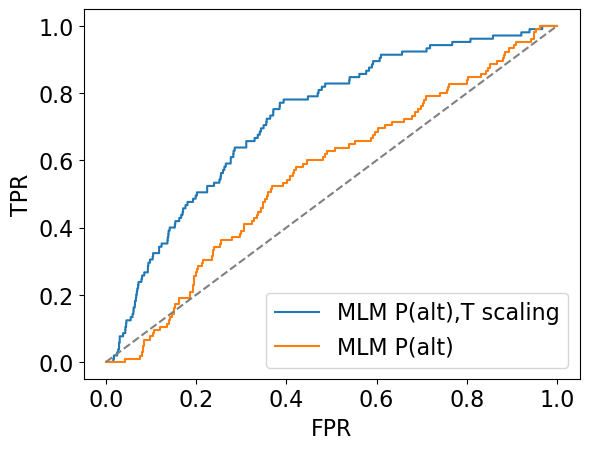

In [58]:
fig, ax = plt.subplots()

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.score)
ax.plot(fpr,tpr, label='MLM P(alt),T scaling')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.score_old)
ax.plot(fpr,tpr, label='MLM P(alt)')

ax.plot(fpr,fpr,color='gray',linestyle='--')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()

print(f'ROC AUC MLM P(alt): {sklearn.metrics.roc_auc_score(df.label, df.score_old):.2}')
print(f'ROC AUC MLM P(alt), T scaling: {sklearn.metrics.roc_auc_score(df.label, df.score):.2}')


ROC AUC MLM P(alt), T scaling: 0.73
ROC AUC PhyloP100: 0.89
ROC AUC PhyloP241: 0.77


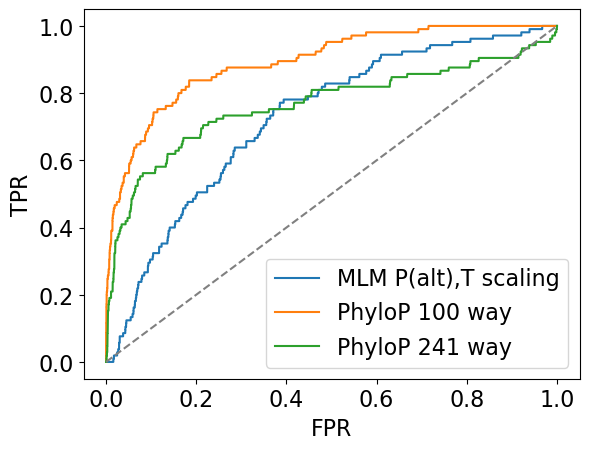

In [59]:
fig, ax = plt.subplots()

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.score)
ax.plot(fpr,tpr, label='MLM P(alt),T scaling')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.PhyloP100)
ax.plot(fpr,tpr, label='PhyloP 100 way')

fpr, tpr, roc_thr = sklearn.metrics.roc_curve(df.label, df.PhyloP241)
ax.plot(fpr,tpr, label='PhyloP 241 way')

ax.plot(fpr,fpr,color='gray',linestyle='--')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()

print(f'ROC AUC MLM P(alt), T scaling: {sklearn.metrics.roc_auc_score(df.label, df.score):.2}')
print(f'ROC AUC PhyloP100: {sklearn.metrics.roc_auc_score(df.label, df.PhyloP100):.2}')
print(f'ROC AUC PhyloP241: {sklearn.metrics.roc_auc_score(df.label, df.PhyloP241):.2}')


In [5]:
PhyloP_df = pd.read_csv(data_dir + 'UTR_coords/PhyloP100_PhyloP241_intersect.tsv', usecols=[2,3],
                       names=['PhyloP100','PhyloP241'], sep=' ',skiprows=lambda x:x%100!=0) #PhyloP100 and PhyloP241 scores in 3'UTR regions

Text(0.5, 0, 'PhyloP 100 way')

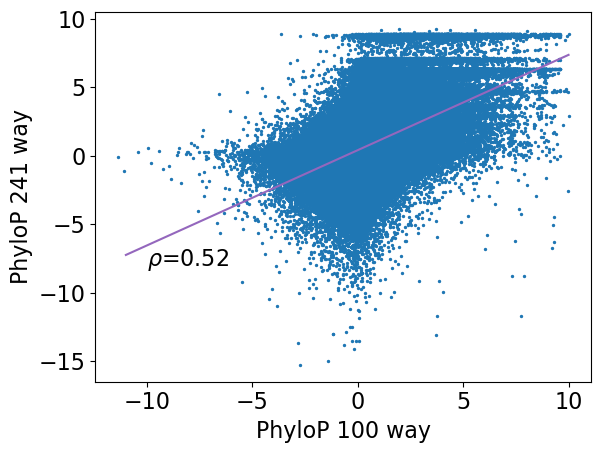

In [15]:
fig, ax = plt.subplots()

scatter = ax.scatter(PhyloP_df.PhyloP100,PhyloP_df.PhyloP241, s=2)
    
pearson_r, p_value = scipy.stats.pearsonr(PhyloP_df.PhyloP100,PhyloP_df.PhyloP241)
        
k, b = np.polyfit(PhyloP_df.PhyloP100,PhyloP_df.PhyloP241,deg=1)
    
    
ax.plot(np.linspace(-11,10), k*np.linspace(-11,10)+b, c='tab:purple')
    
ax.text(x=-10, y=-8, s=r"$\rho$"+f'={pearson_r:.2f}', fontsize=16)

ax.set_ylabel('PhyloP 241 way')
ax.set_xlabel('PhyloP 100 way')